Créditos: Esse notebook é adaptado dos exemplos fornecidos pelo professor Eduardo Bezerra e códigos utilizados no T1.
- Link para o vídeo: XX

## Objetivo do trabalho:
* Apresentar implementações e descrevê-las com detalhes
* Apresentar os resultados
* Explicar em vídeo

# 1 Engenharia de Features

### Resumo:
* Classificação | 1500 exemplos | 11 atributos | credtrain.txt
* Preprocessamentos: ordinal + count enconding e normalização
* Mining: GradientBoostingClassifier

<s> Codificação Target </s>

Tentei utilizar codificação target, mas não gerou nada. A seguinte informação apareceu: "Warning: No categorical columns found. Calling 'transform' will only return input data."

## Seleção dos dados
Primeiramente é necessário baixar a base de dados

In [1]:
import pandas as pd
nome_colunas = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']
data = pd.read_csv('cic1205/data/credtrain.txt', sep='\t', names=nome_colunas)

* O argumento **sep='\t'** detecta separações por tab
* O argumento **names=nome_colunas** foi utilizado para nomear as colunas. Para isso foi criada uma array com os nomes das colunas e passada para o parâmetro

## Preprocessamento
Agora tratarei os atributos categóricos e não categóricos.
* Categóricos: Serão codificados em novas variáveis usando ordinal e target encoding
* Não categóricos: Serão normalizados
* Ambos serão unidos num dataframe final

In [2]:
# Lista de variáveis categóricas
variaveis_categoricas = ['ESCT', 'NDEP', 'TIPOR', 'TEL']

# Lista de variáveis numéricas
variaveis_numericas = ['RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA']

# Dataframe com variaveis categoricas
data_cat = data[variaveis_categoricas]

# Dataframe com variaveis numericas
data_num = data[variaveis_numericas]

### Normalização

In [3]:
from sklearn.preprocessing import MinMaxScaler  # Importando biblioteca de normalização Min-Max
scaler = MinMaxScaler()                         # Objeto que realiza a normalização
scaler.fit(data_num)                            # Ajustando o objeto aos dados

def normalizar(input_df):
    data_num_normalized = pd.DataFrame(             # Cria um dataframe que recebe como input um ndarray (numpy)
    scaler.transform(input_df), columns=input_df.columns # O nd-array é retornado pelo método transform
    )
    return data_num_normalized

data_num_normalized = normalizar(data_num)

### Codificação Ordinal

In [4]:
from sklearn.preprocessing import OrdinalEncoder

# Criando o objeto codificador ordinal
ordinal_encoder = OrdinalEncoder()

# Ajustando o objeto aos dados
ordinal_encoder.fit(data_cat)

# Função para codificar os dados usando Ordinal Encoding
def codificar_ordinal(input_df):
    nparray_encoded = ordinal_encoder.transform(input_df)
    data_cat_encoded = pd.DataFrame(nparray_encoded, columns=input_df.columns)
    return data_cat_encoded

# Codificando os dados
data_cat_encoded_ordinal = codificar_ordinal(data_cat)

### Codificação Contagem

Retornará quantas vezes um elemento aparece no dataset (pode ser útil para contar eventos etc)

In [5]:
from category_encoders import CountEncoder

# Criando o objeto codificador de contagem
count_encoder = CountEncoder()

# Ajustando o objeto aos dados
count_encoder.fit(data_cat)

# Codificando os dados
data_cat_encoded_count = count_encoder.transform(data_cat)

### Concatenando os dataframes preprocessados

In [6]:
data_preprocessed_ordinal = pd.concat( [ data_cat_encoded_ordinal, data_num_normalized, data['CLASSE'] ], axis=1 )

In [7]:
data_preprocessed_count = pd.concat( [ data_cat_encoded_count, data_num_normalized, data['CLASSE'] ], axis=1 )

## Mineração

O resultado de GradientBoosting com One-hot encoding **F1 Macro = 0.90**

### Usando Ordinal encoding com GradientBoosting

In [8]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed_ordinal.iloc[:,:-1], # features
                                                                data_preprocessed_ordinal.iloc[:,-1],  # labels
                                                                test_size=0.10,                 # % do test set (10%)
                                                                random_state=1)                # seed

In [9]:
from sklearn.ensemble import GradientBoostingClassifier  # Importando Classe de treinamento de Aumento de Gradiente
model = GradientBoostingClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingClassifier(random_state=1)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")                            # Ajustando o modelo

Overfitted Accuracy: 94.07%


In [11]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.67%
Confusion Matrix:
 [[69  3]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.96      0.82      0.88        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



#### Preprocessamento para teste do modelo
Como o dataset de teste está em outro arquivo (credtest.txt), será necessário repetir os passos de preprocessamento usando os objetos já treinados na fase de treinamento do modelo. Os passos são:
* Seleção de dados
* Separação dos atributos numéricos e categóricos
* Utilização dos objetos de preprocessamento já criados para transformar os novos dados (scaler e codificador)
* Junção do dataset
* Teste final

In [12]:
test_data = pd.read_csv('cic1205/data/credtest.txt', sep='\t', names=nome_colunas) # Seleção de dados
test_data_cat = test_data[variaveis_categoricas] # Separação dos atributos categóricos
test_data_num = test_data[variaveis_numericas]   # Separação dos atributos categóricos
test_data_cat_encoded = codificar_ordinal(test_data_cat)
test_data_num_normalized = normalizar(test_data_num)   # Normalização
test_data_preprocessed = pd.concat( [ test_data_cat_encoded, test_data_num_normalized, test_data['CLASSE'] ], axis=1 ) # Junção
X_test = test_data_preprocessed.iloc[:,:-1] # Conjuntos de dados
y_test = test_data_preprocessed.iloc[:,-1]  # Classificações

In [13]:
y_pred = model.predict(X_test) # Resultados no set de testes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.43%
Confusion Matrix:
 [[293  13]
 [ 48 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.94      0.82      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



### Usando Count encoding com GradientBoosting

In [14]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed_count.iloc[:,:-1], # features
                                                                data_preprocessed_count.iloc[:,-1],  # labels
                                                                test_size=0.10,                 # % do test set (10%)
                                                                random_state=1)                # seed

In [15]:
from sklearn.ensemble import GradientBoostingClassifier  # Importando Classe de treinamento de Aumento de Gradiente
model = GradientBoostingClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingClassifier(random_state=1)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")                            # Ajustando o modelo

Overfitted Accuracy: 94.07%


In [17]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.67%
Confusion Matrix:
 [[69  3]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.96      0.82      0.88        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



#### Preprocessamento para teste do modelo
Como o dataset de teste está em outro arquivo (credtest.txt), será necessário repetir os passos de preprocessamento usando os objetos já treinados na fase de treinamento do modelo. Os passos são:
* Seleção de dados
* Separação dos atributos numéricos e categóricos
* Utilização dos objetos de preprocessamento já criados para transformar os novos dados (scaler e codificador)
* Junção do dataset
* Teste final

In [18]:
test_data = pd.read_csv('cic1205/data/credtest.txt', sep='\t', names=nome_colunas) # Seleção de dados
test_data_cat = test_data[variaveis_categoricas] # Separação dos atributos categóricos
test_data_num = test_data[variaveis_numericas]   # Separação dos atributos categóricos
test_data_cat_encoded = count_encoder.transform(test_data_cat)
test_data_num_normalized = normalizar(test_data_num)   # Normalização
test_data_preprocessed = pd.concat( [ test_data_cat_encoded, test_data_num_normalized, test_data['CLASSE'] ], axis=1 ) # Junção
X_test = test_data_preprocessed.iloc[:,:-1] # Conjuntos de dados
y_test = test_data_preprocessed.iloc[:,-1]  # Classificações

In [19]:
y_pred = model.predict(X_test) # Resultados no set de testes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.43%
Confusion Matrix:
 [[293  13]
 [ 48 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.94      0.82      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



### Análise comparativa de resultados (F1-Macro avg):
- One-hot encoding: 0.90
- Ordinal encoding: 0.89
- Count encoding: 0.89

# 2 Validação Cruzada

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: binarização
* Mining: GradientBoostingClassifier com CrossValidation
* Tarefa: Hyperparameter Tunning com Stritified5Fold Validation

In [20]:
import numpy as np
import pickle
fileA602 = open('cic1205/data/atmoseer/A602.pickle' , 'rb')
fileA621 = open('cic1205/data/atmoseer/A621.pickle' , 'rb')
fileA627 = open('cic1205/data/atmoseer/A627.pickle' , 'rb')
fileA636 = open('cic1205/data/atmoseer/A636.pickle' , 'rb')
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')

### Dataset A602

In [21]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA602)

In [22]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [23]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 6],
    'subsample': [0.3, 0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


**Busca 1**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 2**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

In [24]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.89%
Confusion Matrix:
 [[633  40]
 [ 45  47]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       673
         1.0       0.54      0.51      0.53        92

    accuracy                           0.89       765
   macro avg       0.74      0.73      0.73       765
weighted avg       0.89      0.89      0.89       765



#### Resultados A602
- F1 Classe 1 antigo: 0.54
- F1 Classe 1 novo: 0.53

### Dataset A621

In [25]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA621)

In [26]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [27]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 6],
    'subsample': [0.3, 0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


**Busca 1**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 2**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 3**: Mesmo que busca 2

In [28]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.24%
Confusion Matrix:
 [[8943  204]
 [ 477  456]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      9147
         1.0       0.69      0.49      0.57       933

    accuracy                           0.93     10080
   macro avg       0.82      0.73      0.77     10080
weighted avg       0.93      0.93      0.93     10080



#### Resultados A621
- F1 Classe 1 antigo: 0.58
- F1 Classe 1 novo: 0.57

### Dataset A627

In [29]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA627)

In [30]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

In [32]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.36%
Confusion Matrix:
 [[8928  272]
 [ 405  597]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      9200
         1.0       0.69      0.60      0.64      1002

    accuracy                           0.93     10202
   macro avg       0.82      0.78      0.80     10202
weighted avg       0.93      0.93      0.93     10202



#### Resultados A627
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.63

### Dataset A636

In [33]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA636)

In [34]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [35]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}

In [36]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 92.49%
Confusion Matrix:
 [[8772  245]
 [ 516  596]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      9017
         1.0       0.71      0.54      0.61      1112

    accuracy                           0.92     10129
   macro avg       0.83      0.75      0.78     10129
weighted avg       0.92      0.92      0.92     10129



#### Resultados A636
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.57

### Dataset A652

In [37]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)

In [38]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [39]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}

In [40]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.82%
Confusion Matrix:
 [[8704   65]
 [ 527  286]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.81      0.35      0.49       813

    accuracy                           0.94      9582
   macro avg       0.88      0.67      0.73      9582
weighted avg       0.93      0.94      0.93      9582



#### Resultados A652
- F1 Classe 1 antigo: 0.50
- F1 Classe 1 novo: 0.48

# 3 Classificação Multi-classes

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: Discretização em 5 classes
* Mining: GradientBoostingClassifier com EarlyStopping

In [54]:
import numpy as np
import pickle
fileA602 = open('cic1205/data/atmoseer/A602.pickle' , 'rb')
fileA621 = open('cic1205/data/atmoseer/A621.pickle' , 'rb')
fileA627 = open('cic1205/data/atmoseer/A627.pickle' , 'rb')
fileA636 = open('cic1205/data/atmoseer/A636.pickle' , 'rb')
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')

### Dataset A602

In [55]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA602)

In [56]:
#Unindo dataset de treino e validação
#X_train = np.concatenate([X_train, X_val], axis=0)
#y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [72]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model.predict(X_test)

[0]	validation_0-merror:0.04913	validation_0-mlogloss:0.91583	validation_1-merror:0.07122	validation_1-mlogloss:0.92782
[1]	validation_0-merror:0.04692	validation_0-mlogloss:0.66947	validation_1-merror:0.06876	validation_1-mlogloss:0.69068
[2]	validation_0-merror:0.04557	validation_0-mlogloss:0.51401	validation_1-merror:0.06925	validation_1-mlogloss:0.54285
[3]	validation_0-merror:0.04213	validation_0-mlogloss:0.40788	validation_1-merror:0.06974	validation_1-mlogloss:0.44398
[4]	validation_0-merror:0.04139	validation_0-mlogloss:0.33397	validation_1-merror:0.07073	validation_1-mlogloss:0.37531
[5]	validation_0-merror:0.04065	validation_0-mlogloss:0.28117	validation_1-merror:0.07024	validation_1-mlogloss:0.32859
[6]	validation_0-merror:0.03943	validation_0-mlogloss:0.24261	validation_1-merror:0.07220	validation_1-mlogloss:0.29458
[7]	validation_0-merror:0.03721	validation_0-mlogloss:0.21432	validation_1-merror:0.07024	validation_1-mlogloss:0.27109
[8]	validation_0-merror:0.03672	validati

C:\Users\miche\anaconda3\envs\ShallowLearning\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-merror:0.03611	validation_0-mlogloss:0.17600	validation_1-merror:0.06974	validation_1-mlogloss:0.24267
[10]	validation_0-merror:0.03513	validation_0-mlogloss:0.16270	validation_1-merror:0.07073	validation_1-mlogloss:0.23497
[11]	validation_0-merror:0.03390	validation_0-mlogloss:0.15138	validation_1-merror:0.07122	validation_1-mlogloss:0.23055
[12]	validation_0-merror:0.03292	validation_0-mlogloss:0.14279	validation_1-merror:0.07024	validation_1-mlogloss:0.22639
[13]	validation_0-merror:0.03255	validation_0-mlogloss:0.13591	validation_1-merror:0.07073	validation_1-mlogloss:0.22299
[14]	validation_0-merror:0.03120	validation_0-mlogloss:0.12873	validation_1-merror:0.07122	validation_1-mlogloss:0.22071
[15]	validation_0-merror:0.03095	validation_0-mlogloss:0.12372	validation_1-merror:0.07122	validation_1-mlogloss:0.22009
[16]	validation_0-merror:0.03058	validation_0-mlogloss:0.11926	validation_1-merror:0.07122	validation_1-mlogloss:0.21955
[17]	validation_0-merror:0.03009	

[77]	validation_0-merror:0.00332	validation_0-mlogloss:0.02800	validation_1-merror:0.07269	validation_1-mlogloss:0.24439
[78]	validation_0-merror:0.00344	validation_0-mlogloss:0.02761	validation_1-merror:0.07269	validation_1-mlogloss:0.24523
[79]	validation_0-merror:0.00344	validation_0-mlogloss:0.02688	validation_1-merror:0.07269	validation_1-mlogloss:0.24556
[80]	validation_0-merror:0.00307	validation_0-mlogloss:0.02625	validation_1-merror:0.07269	validation_1-mlogloss:0.24648
[81]	validation_0-merror:0.00258	validation_0-mlogloss:0.02552	validation_1-merror:0.07318	validation_1-mlogloss:0.24677
[82]	validation_0-merror:0.00258	validation_0-mlogloss:0.02530	validation_1-merror:0.07318	validation_1-mlogloss:0.24714
[83]	validation_0-merror:0.00258	validation_0-mlogloss:0.02512	validation_1-merror:0.07367	validation_1-mlogloss:0.24758
[84]	validation_0-merror:0.00258	validation_0-mlogloss:0.02457	validation_1-merror:0.07367	validation_1-mlogloss:0.24842
[85]	validation_0-merror:0.00246

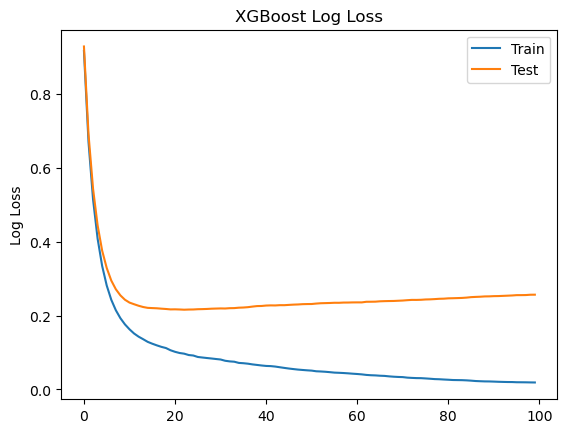

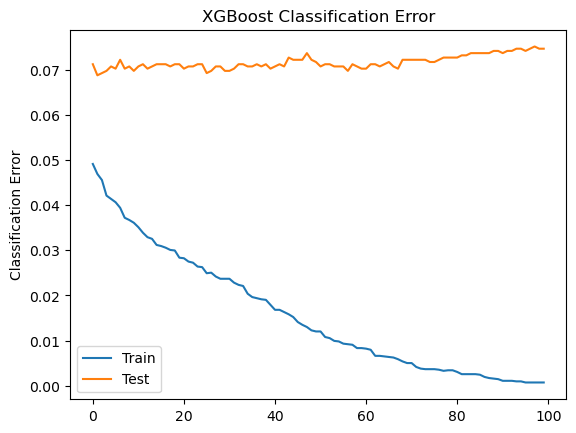

In [73]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

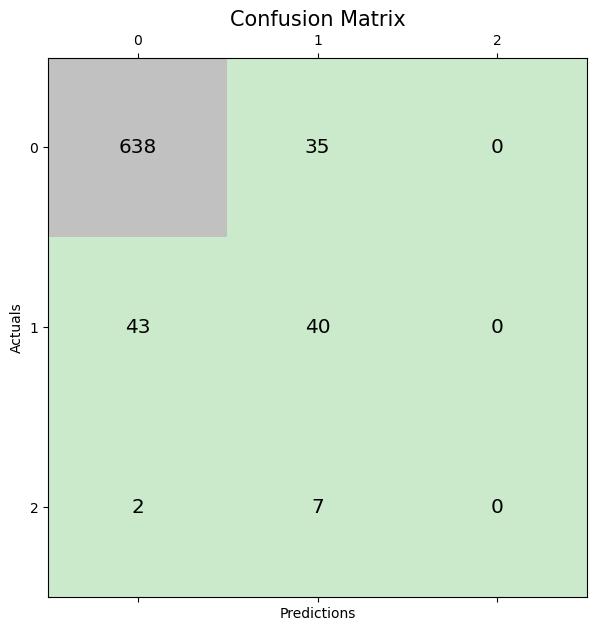

In [71]:
def evaluate_model(y_test, y_pred, header):
    # make predictions for test data
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

    precision =  round(precision_score(y_test, y_pred, average='macro', zero_division=1), 4)
    recall = round(recall_score(y_test, y_pred, average='macro', zero_division=1), 4)
    F1 =  round(f1_score(y_test, y_pred, average='macro', zero_division=1), 4)
    metrics = [precision, recall, F1]

    results = pd.DataFrame(metrics)
    results.index = ['Precision', 'Recall', 'F1_score']
    results.columns = [header]
    results

evaluate_model(y_test, y_pred, 'With Early Stopping')

In [78]:
# Predição
y_pred = model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.10%
Confusion Matrix:
 [[635  38   0]
 [ 44  37   2]
 [  4   3   2]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       673
         1.0       0.47      0.45      0.46        83
         2.0       0.50      0.22      0.31         9

    accuracy                           0.88       765
   macro avg       0.63      0.54      0.57       765
weighted avg       0.88      0.88      0.88       765



#### Resultados A602
- F1 Classe 1 antigo: 0.54
- F1 Classe 1 novo: 0.53
- F1 Classes 1 e 2: 0.46 e 0.31